# Fake news recognition using a Multinomial Naive Bayes Classifier

### Course: Advanced Statistics for Physics Analysis
### Students: Toso Simone, Feltrin Antonio

In [1]:
library(tidyverse)
library(stringr)
library(tm)             #Text-mining package
library(NLP) 
library(textstem)      #For lemmatization

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.2.0
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: NLP


Attaching package: ‘NLP’


The following object is masked from ‘package:ggplot2’:

    annotate


Loading required package: koRpus.lang.en

Loading required package: koRpus

Loading required package: sylly

For information on available language packages for 'koRpus', run

  available.koRpus.lang()

and see ?install.koRpus.lang()



Attaching package: ‘koRpus’


The following object is masked from ‘package:tm’:

    readTagged


The followin

# A bit of theory

Our aim is to *classify* some phrases, using a predetermined set of categories $\mathcal{C}$ (e.g. `{Fake, Not Fake}`).

To do so, we must learn a *classification function* $\gamma: \mathcal{X} \to \mathcal{C}$, where $\mathcal{X}$ is the set of all possible input phrases. 

There are many possible algorithms for text classification in natural language processing. In this project we will focus on the *Multinomial Naive Bayes* classifier.

### The MNB classifier
Given a class $c$ and a *document* (i.e. phrase) $d$, we can imagine that the document was composed by randomly extracting words from the total set of tokens $\mathcal{T} = \{t_1, t_2, \dots, t_m\}$. This way, the probability of composing the observed document would be

$P(d|c) = \prod_{1 \leq k \leq n_d} p(t_k|c)$.

Now, we want to infer $P(c|d)$. This can be done though Bayes's Theorem:

$P(c|d) \propto p(c) \prod_{1 \leq k \leq n_d} p(t_k|c)$.

We can then easily find the *maximum a posteriori* class $c_{map}$:

$c_{map} = \mathrm{argmax}_{c} P(d|c)$.

The maximum a posteriori class will be our guess for the classification.

### The learning algorithm
Our model depends on the following parameters:
* **Prior**: $p(c)$. 
* **Token probability**: $p(t_k|c)$, the probability for token $t_k$ to appear in a document of class $c$. 

The prior can be estimated as $\hat{p}(c) = \frac{N_c}{N}$, i.e. the fraction of documents of class $c$ in the training set.

The token probability can instead be estimated as $\hat{p}(t|c) = \frac{T_{ct} + 1}{\sum_{t'} (T_{ct' + 1})}$. The term $T_{ct}$ is the number of times token $t$ appears in a document of class $c$. Notice that, both at the numerator and denominator, we are adding $1$ to $T_{ct}$ and $T_{ct'}$. This is done in order to avoid having $p(t|c) = 0$ for tokens that never appear in documents of class $c$.

<hr style="border:1px solid gray">


# Kumar dataset 

We first try our hand on [this](https://www.kaggle.com/datasets/anmolkumar/fake-news-content-detection?select=train.csv) dataset. It consists of 11507 records (10240 for training, 1267 for testing)

Each entry is classified as one of these 6 categories:
* *Barely true* - 0
* *False* - 1
* *Half-true* - 2
* *Mostly true* - 3
* *Not known* - 4
* *True* - 5

## Read the data

In [2]:
dir_input <- 'data/kumar/train_pruned.csv'
dir_test <- 'data/kumar/test.csv'
input.df <- read.csv(dir_input,header=TRUE,sep=',')
test.df <- read.csv(dir_test,header=TRUE,sep=',')

In [3]:
head(input.df)

,Labels,Text,Text_Tag
,<int>,<chr>,<chr>
1,1,Says the Annies List political group supports third-trimester abortions on demand.,abortion
2,2,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments"
3,3,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",foreign-policy
4,1,Health care reform legislation is likely to mandate free sex change surgeries.,health-care
5,2,The economic turnaround started at the end of my term.,"economy,jobs"
6,5,The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades.,education


## Change the labelling
The original labelling doesn't make a lot of sense to us, since a higher label does not necessarily mean a higher "degree of truth". Therefore we change the labelling to the following:
* *Not known* 0
* *False* 1
* *Barely true* - 2
* *Half-true* - 3
* *Mostly true* - 4
* *True* - 5


In [4]:
for(i in 1:length(input.df$Labels)){
    input.df$Labels[i] <- switch(as.character(input.df$Labels[i]), "0" = 2, "1" = 1, "2" = 3, 
                                 "3" = 4, "4" = 0, "5" = 5)
}

In [5]:
head(input.df)

,Labels,Text,Text_Tag
,<dbl>,<chr>,<chr>
1,1,Says the Annies List political group supports third-trimester abortions on demand.,abortion
2,3,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments"
3,4,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",foreign-policy
4,1,Health care reform legislation is likely to mandate free sex change surgeries.,health-care
5,3,The economic turnaround started at the end of my term.,"economy,jobs"
6,5,The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades.,education


## Vocabulary construction and tokenization
We want to extract the single words from each document and perform some operations (punctuation removal, lemmatisation, token normalization).

#### Stopwords / punctuation removal

In [6]:
#Removes punctuation, uppercase to lowercase
plain <- function(word,punct='[:punct:]'){
    word <- str_to_lower(str_replace_all(word,punct,' '))
    return(word) 
}

#Gets all unique words from the list of records
get.unique.words <- function (tags.bag,sep,sortit=FALSE) {
    all.tags <- c()
    for (record in tags.bag){
        temp.tags <- str_split_1(plain(record),sep)
        for (word in temp.tags) {
            word <- plain(word)
            if (word %in% all.tags == FALSE & word != '') {
                    all.tags <- c(all.tags,str_to_lower(word))
                } 
            }
        }
    if (sortit) {all.tags <- sort(all.tags)}
    return(all.tags)
}

#Removes all stopwords, punctuation etc. from the records
get.quotes <- function (quotes.bag,sep) {
    all.quotes <- list()
    for (record in quotes.bag){
        temp.q <- str_split_1(plain(record),sep)
        temp.q <- str_flatten(temp.q[!(temp.q %in% stopwords('en')) & str_length(temp.q)>0], collapse = ' ') #>1 to remove lone letters? no because of $
        all.quotes <- c(all.quotes,temp.q)
        }

    return(all.quotes)
}

#Get all unique tags (could be useful)
get.tags <- function (tags.bag,sep) {
    all.quotes <- list()
    for (record in tags.bag){
        #cat('\nrecord, type',record,typeof(record))
        temp.q <- str_split(plain(record,punct = '[.;()]'),sep)
        temp.q <- str_flatten(temp.q[[1]][!(temp.q %in% stopwords('en'))],  collapse = ' ') #>1 to remove lone letters? no because of $
        all.quotes <- c(all.quotes,temp.q)
        }

    return(all.quotes)
}

In [7]:
#Queste due righe possiamo toglierle giusto?

#input.tags <- get.unique.words(input.df$Text_Tag,sep=',',sortit=TRUE)
#test.tags <- get.unique.words(test.df$Text_Tag,sep=',',sortit=TRUE)    

In [8]:
#Create training dataframe, in which stopwords and punctuation are removed
quotes <- get.quotes(input.df$Text,sep=' ')
tags <- get.tags(input.df$Text_Tag,sep=',')

train.df <- data.frame(Labels = input.df$Labels, Text = unlist(quotes), Text_Tag = unlist(tags))

In [9]:
head(train.df)

,Labels,Text,Text_Tag
,<dbl>,<chr>,<chr>
1,1,says annies list political group supports third trimester abortions demand,abortion
2,3,decline coal start started natural gas took started begin president george w bushs administration,energy history job-accomplishments
3,4,hillary clinton agrees john mccain voting give george bush benefit doubt iran,foreign-policy
4,1,health care reform legislation likely mandate free sex change surgeries,health-care
5,3,economic turnaround started end term,economy jobs
6,5,chicago bears starting quarterbacks last 10 years total number tenured uw faculty fired last two decades,education


#### Lemmatization
Now, we want to *lemmatize* the records. This means that all terms are converted to their "base form".

E.g.
 - "words" $\to$ "word"
 - "says" $\to$ "say"
 
etc...

This can be easily done thanks to the ```lemmatize_strings()``` function contained in the ```textstem``` package.

In [10]:
#Perform lemmatization
train.df$Text <- lemmatize_strings(train.df$Text)

In [11]:
head(train.df)

,Labels,Text,Text_Tag
,<dbl>,<chr>,<chr>
1,1,say annies list political group support 3 trimester abortion demand,abortion
2,3,decline coal start start natural gas take start begin president george w bushs administration,energy history job-accomplishments
3,4,hillary clinton agree john mccain vote give george bush benefit doubt iran,foreign-policy
4,1,health care reform legislation likely mandate free sex change surgery,health-care
5,3,economic turnaround start end term,economy jobs
6,5,chicago bear start quarterback last 10 year total numb tenure uw faculty fire last two decade,education


#### Token normalization: 
We now perform *token normalization*: we want words with similar meaning to be considered as identical. 

For example, it wouldn't make much sense for the model to treat "<span>&#36;</span>15" and "<span>&#36;</span>81" as two different tokens. Instead, we would like to count them as a unique "&lt;MONEY&gt;" token. 

Similarly, the tokens "1931", "1982" and "2011" should all fall into "&lt;YEAR&gt;".

In [12]:
# $1234 --> <MONEY>
train.df$Text <- str_replace_all(train.df$Text, regex("\\$[0-9]*"), "<MONEY>")

In [13]:
# 1945, 2013, 2042 --> <YEAR>
train.df$Text <- str_replace_all(train.df$Text, regex("(18|19|20)\\d{2}"), "<YEAR>")

In [14]:
# 12345... --> <NUMBER>
train.df$Text <- str_replace_all(train.df$Text, regex("\\d+"), "<NUMBER>")

In [15]:
head(train.df, 15)

,Labels,Text,Text_Tag
,<dbl>,<chr>,<chr>
1,1,say annies list political group support <NUMBER> trimester abortion demand,abortion
2,3,decline coal start start natural gas take start begin president george w bushs administration,energy history job-accomplishments
3,4,hillary clinton agree john mccain vote give george bush benefit doubt iran,foreign-policy
4,1,health care reform legislation likely mandate free sex change surgery,health-care
5,3,economic turnaround start end term,economy jobs
6,5,chicago bear start quarterback last <NUMBER> year total numb tenure uw faculty fire last two decade,education
7,2,jim dunnam live district represent year now,candidates-biography
8,3,be person stage work actively just last year pass along russ feingold tough ethic reform since watergate,ethics
9,3,however take <MONEY> <NUMBER> million oregon lottery fund port newport eventually land new noaa marine operation center pacific,jobs


In [16]:
# Possiamo anche rimuovere vocabulary giusto?
vocabulary <- get.unique.words(train.df$Text,sep=' ')

## Vocabulary building 

#### We take part of the dataset (e.g. the first 80% of the records) and construct our vocabulary, which will be used for training. 
#### The remaining 20% will serve for validation.

In [17]:
validation.df <- train.df[ceiling(0.8*nrow(train.df)):nrow(train.df),]
train.df <- train.df[1:ceiling(0.8*nrow(train.df)),]

### vocab.df, to store how many times each word appears

In [18]:
find.vocabulary <- function(N, unique=FALSE){
    vocabulary.df <- data.frame("Token" = vocabulary[1], "Class_0" = 0, "Class_1" = 0, "Class_2" = 0, "Class_3" = 0, "Class_4" = 0,
                       "Class_5" = 0)
    for (i in 1:N){
        record <- train.df$Text[i]
        class <- train.df$Labels[i]
        temp.q <- str_split_1(plain(record), " ")
        if(unique){
            temp.q <- unique(temp.q)
        }
        
        for(word in temp.q){
            if(!(word %in% vocabulary.df$Token)){
                classes <- rep(0, 6)
                classes[class + 1] <- 1
                vocabulary.df <- rbind(vocabulary.df, list(word, classes[1], classes[2], 
                                                 classes[3], classes[4], classes[5], classes[6]))
            }
            else{
                #Trova dove sta la parola --> somma 1 al contatore della classe
                vocabulary.df[which(vocabulary.df$Token == word), class + 2] <- vocabulary.df[which(vocabulary.df$Token == word), class + 2] + 1
            }
        }
    }
    return(vocabulary.df)
}

In [19]:
n.records <- length(train.df$Text) #Number of records
vocab.df <- find.vocabulary(n.records)

### vocab.bool.df --> here we store in how many documents of each class the word appears

In [20]:
vocab.bool.df <- find.vocabulary(n.records, TRUE)

In [21]:
head(vocab.bool.df, 8)

,Token,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,say,209,430,410,442,371,304
2,annies,0,1,0,0,0,0
3,list,1,2,4,6,5,5
4,political,1,12,3,6,8,9
5,group,11,13,13,6,4,3
6,support,12,52,56,66,42,32
7,<number>,135,400,382,590,594,443
8,trimester,0,2,0,0,0,0


## Feature selection

We must now perform feature selection: this means selecting a subset of the vocabulary and use that subset for classification.

### $\chi^2$ method


In [22]:
#CHI2

CHIs <- rep(0, length(vocab.bool.df$Token))                     #Vector with Chi^2 values
NCs <- hist(train.df$Labels,breaks=seq(-1,5),plot=FALSE)$counts #Number of documents for each class

In [23]:
for(i in 1:length(vocab.bool.df$Token)){
    Chi <- 0
    N.t <- sum(vocab.bool.df[i, 2:7])
    N.nott <- n.records - N.t 
    for(class in 0:5){
        N.c <- NCs[class + 1]
        N.ct <- vocab.bool.df[i, class + 2]
        E <- n.records * N.c/n.records * N.t/n.records
        Chi <- Chi + (N.ct - E)^2 / E
        
        # N_c,nontoken - E_c, nontoken 
        N.c.nott <- N.c - N.ct
        E <- n.records * N.c/n.records * N.nott/n.records
        Chi <- Chi + (N.c.nott - E)^2 / E
    }
    
    CHIs[i] <- Chi
}

In [24]:
#Now CHIs contains the chi^2 for each token --> let's try ranking them
vocab.df$Chi <- CHIs

In [25]:
vocab.bool.df$Chi <- CHIs

In [26]:
vocab.df[order(vocab.df$Chi, decreasing = TRUE),]

,Token,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Chi
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7,<number>,204,609,553,974,938,729,106.61974
732,socialist,10,1,1,0,0,1,84.35517
167,rep,30,19,25,16,5,10,77.77005
150,percent,34,115,121,228,233,193,62.54439
1,say,233,465,442,473,398,326,43.91115
79,since,14,30,30,74,67,69,40.23848
263,obama,76,130,106,131,86,68,39.15072
2781,duffy,4,1,0,0,0,0,35.93560
135,cut,12,44,68,99,72,40,35.71443


We don't really like that the $\chi^2$ method seems to like terms which appear only in one class. This can be misguiding, so let's try with the Mutual Information.

## Mutual Information 
We evaluate the mutual information for each class (among the possibilities (class, not class)) and make an average.

$\sum_{\mathrm{class}\in\{0,1\}}\sum_{\mathrm{token}\in\{0,1\}}P(class, token) \log{\frac{P(class, token)}{P(class)P(token)}}$

In [27]:
MIs <- rep(0, length(vocab.bool.df$Token))
cat(str(MIs))

#Evaluate MI separately for each class, then average
for(i in 1:length(vocab.df$Token)){
    MI <- 0
    N.t <- sum(vocab.bool.df[i, 2:7])
    N.not.t <- n.records - N.t
    for(class in 0:5){
        MI.c <- 0
        N.c <- NCs[class + 1]
        N.not.c <- n.records - N.c 
        N.ct <- vocab.bool.df[i, class + 2]
        
        class.index <- switch(class + 1, "Class_0", "Class_1", "Class_2", "Class_3", "Class_4", "Class_5")
        N.not.c.not.t <- n.records - sum(vocab.bool.df[i, 2:7]) + N.ct - sum(vocab.bool.df$class.index)
        
        
        #P(class, token)log(...) + P(nonclass, token) + P(class, non token) + P(non class, non token)
        term <- ifelse(N.ct > 0, N.ct/n.records*log(N.ct*n.records/(N.c*N.t)), 0) + 
                ifelse((N.t - N.ct) > 0, (N.t - N.ct)/n.records*log((N.t-N.ct)*n.records/(N.not.c*N.t)), 0)+
                ifelse((N.c - N.ct) > 0, (N.c - N.ct)/n.records*log((N.c - N.ct)*n.records/(N.c * (N.not.t))), 0) + 
                ifelse(N.not.c.not.t > 0, N.not.c.not.t/n.records * log(N.not.c.not.t*n.records / (N.not.c * N.not.t)), 0)
                
        MI <- MI + term
        
    }
    
    MIs[i] <- MI
}

 num [1:7794] 0 0 0 0 0 0 0 0 0 0 ...


In [28]:
vocab.df$MI <- MIs

In [29]:
vocab.df.order.MI <- vocab.df[order(vocab.df$MI, decreasing = TRUE), ]

# Training and validation

We compute the parameters of our MNB, using different numbers of features. We train it on different vocabulary sizes.

In [30]:
length(vocab.df$Token)

[1] 7794

In [31]:
vocab.sizes <- c(100, 500, 1000, 1500, 2000 , 5000)

#### Score for different vocabulary sizes

In [32]:
#Returns accuracy of feature selection with *size* best features
validate <- function(size){
    scores <- rep(0, length(vocab.sizes))
    vocab.short <- vocab.df.order.MI[1:size, ]
    
    #Prior
    p.c <- log(NCs / n.records)

    posteriors.df <- vocab.short

    for(class in 0:5){
        posteriors.df[, class + 2] <- log(posteriors.df[, class + 2] / sum(posteriors.df[, class + 2]))
    } 
    
    predictions <- rep(0, length(validation.df$Text))
    for(i in 1:length(validation.df$Text)){
        record <- validation.df$Text[i]
        words <- str_split_1(plain(record), " ") 
        posteriors <- rep(0, 6) #Posterior probabilities (we want to find the maximum)
        for(class in 0:5){
            #For each class evaluate posterior
            posterior <- p.c[class + 1]
            for(word in words){
                #Check if word in vocabulary
                if(word %in% posteriors.df$Token){
                    posterior <- posterior + posteriors.df[which(posteriors.df$Token == word) , class + 2]
                }
            }
            posteriors[class + 1] <- posterior
        }

        predictions[i] <- which.max(posteriors) - 1
    }
    
    return(sum(predictions == validation.df$Labels) / length(validation.df$Labels))
 
}


In [33]:
scores <- rep(0, 6)
for(i in 1:length(vocab.sizes)){
    scores[i] <- validate(vocab.sizes[i])
}
scores.results <- data.frame(vocab.sizes, scores)

In [34]:
scores.results[which.max(scores.results$scores),]

,vocab.sizes,scores
,<dbl>,<dbl>
2,500,0.2363281


#### Confusion matrix
We want to plot the confusion matrices, just to check what it is doing.

In [35]:
fit <- function(size){
        scores <- rep(0, length(vocab.sizes))
    vocab.short <- vocab.df.order.MI[1:size, ]
    
    #Prior
    p.c <- log(NCs / n.records)

    posteriors.df <- vocab.short

    for(class in 0:5){
        posteriors.df[, class + 2] <- log(posteriors.df[, class + 2] / sum(posteriors.df[, class + 2]))
    } 
    
    predictions <- rep(0, length(validation.df$Text))
    for(i in 1:length(validation.df$Text)){
        record <- validation.df$Text[i]
        words <- str_split_1(plain(record), " ") 
        posteriors <- rep(0, 6) #Posterior probabilities (we want to find the maximum)
        for(class in 0:5){
            #For each class evaluate posterior
            posterior <- p.c[class + 1]
            for(word in words){
                #Check if word in vocabulary
                if(word %in% posteriors.df$Token){
                    posterior <- posterior + posteriors.df[which(posteriors.df$Token == word) , class + 2]
                }
            }
            posteriors[class + 1] <- posterior
        }

        predictions[i] <- which.max(posteriors) - 1
    }
    
    return(predictions)
}

In [49]:
# Fit data for 550 tokens
fit.550 <- fit(550)
 
# Evaluate confusion matrix
confusion.matrix <- matrix(0, 6, 6)

for(i in 1:length(fit.550)){
    confusion.matrix[validation.df$Labels[i] + 1, fit.550[i] + 1] <- confusion.matrix[validation.df$Labels[i] + 1, fit.550[i] + 1] + 1
}

confusion.matrix <- data.frame(confusion.matrix)

#Normalize along rows
confusion.matrix <- confusion.matrix / apply(confusion.matrix, 1, sum)

#Set colnames
colnames(confusion.matrix) <- c("Not Known", "False", "Barely True", "Half-True", "Mostly True", "True")
rownames(confusion.matrix) <- c("Not Known", "False", "Barely True", "Half-True", "Mostly True", "True")

In [50]:
confusion.matrix

,Not Known,False,Barely True,Half-True,Mostly True,True
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Not Known,0.18681319,0.2747253,0.2307692,0.1318681,0.07142857,0.1043956
False,0.07980050,0.2593516,0.1620948,0.2069825,0.18453865,0.1072319
Barely True,0.05830904,0.1953353,0.2011662,0.2274052,0.19241983,0.1253644
Half-True,0.04807692,0.1682692,0.1706731,0.2475962,0.22115385,0.1442308
Mostly True,0.02099738,0.1863517,0.1207349,0.2047244,0.30708661,0.1601050
True,0.04307692,0.1630769,0.1384615,0.1753846,0.29846154,0.1815385


In [46]:
?heatmap

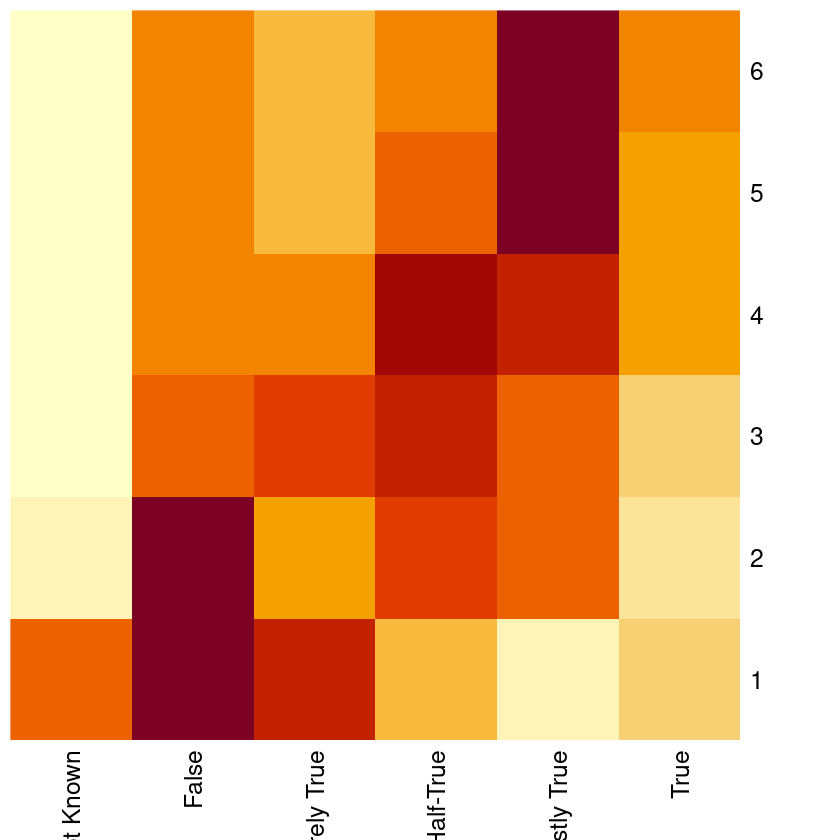

In [48]:
heatmap(as.matrix(confusion.matrix), Rowv=NA, Colv = NA,  keep.dendro = FALSE)

In [60]:
confusion.data.frame <- data.frame(row=character(0),col=character(0), confusion=numeric(0))
for(i in 1:length(rownames(confusion.matrix))){
    for(j in 1:length(colnames(confusion.matrix))){
        confusion.data.frame <- rbind(confusion.data.frame, list(rownames(confusion.matrix)[i],
                                                                colnames(confusion.matrix[j]), confusion.matrix[i,j]))
    }
}

colnames(confusion.data.frame) <- c("row", "col", "confusion")

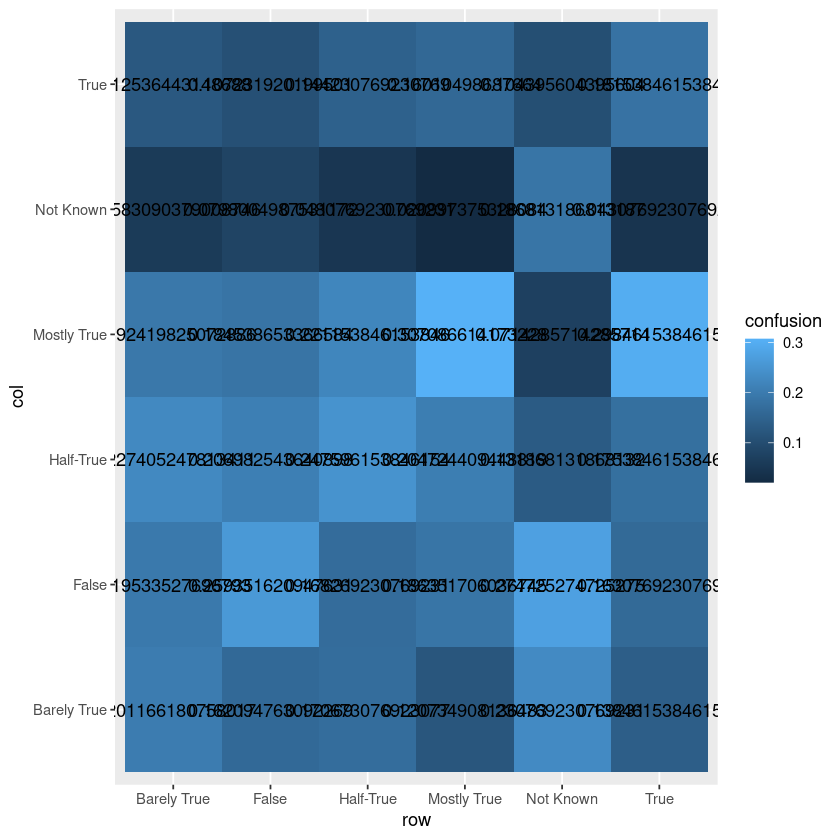

In [62]:
ggp <- ggplot(confusion.data.frame, aes(row, col)) +    # Create default ggplot2 heatmap
  geom_tile(aes(fill = confusion))

ggp +                                         # Add values to heatmap
  geom_text(aes(label = confusion))